
# First attempt at predicting ZRI

Use Zip_Zri_AllHomesPlusMultifamily as label and features from the census information zip_codes_2015_5yr

In [2]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option("max_rows", None)
from matplotlib import pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

from google.cloud import bigquery
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="adept-comfort-307720-db5f8ca3ee46.json"
client = bigquery.Client()


Load the datasets

In [3]:
%load_ext google.cloud.bigquery

In [5]:
%%bigquery zip_codes_2015_5yr

SELECT *
FROM
    `bigquery-public-data.census_bureau_acs.zip_codes_2015_5yr`


Downloading: 100%|██████████| 33120/33120 [00:22<00:00, 1444.80rows/s]


In [7]:
zri_mult = pd.read_csv('./data/Zip_Zri_MultifamilyResidenceRental.csv')
zri_mult.shape
#this dataset has very few rows, so I'll start with the dataset of all the homes

(1861, 120)

In [37]:
zri_mult['RegionID'] = zri_mult['RegionID'].astype(str)

In [38]:
zri_all = pd.read_csv('./data/Zip_Zri_AllHomesPlusMultifamily.csv')
zri_all.head() 

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,2010-09,2010-10,2010-11,2010-12,2011-01,2011-02,2011-03,2011-04,2011-05,2011-06,2011-07,2011-08,2011-09,2011-10,2011-11,2011-12,2012-01,2012-02,2012-03,2012-04,2012-05,2012-06,2012-07,2012-08,2012-09,2012-10,2012-11,2012-12,2013-01,2013-02,2013-03,2013-04,2013-05,2013-06,2013-07,2013-08,2013-09,2013-10,2013-11,2013-12,2014-01,2014-02,2014-03,2014-04,2014-05,2014-06,2014-07,2014-08,2014-09,2014-10,2014-11,2014-12,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,2018-05,2018-06,2018-07,2018-08,2018-09,2018-10,2018-11,2018-12,2019-01,2019-02,2019-03,2019-04,2019-05,2019-06,2019-07,2019-08,2019-09,2019-10,2019-11,2019-12,2020-01
0,61639,10025,New York,NY,New York-Newark-Jersey City,New York County,1,3031.0,3058.0,3031.0,3015.0,2976.0,2914.0,2860.0,2811.0,2792.0,2799.0,2820.0,2852.0,2885.0,2905.0,2883.0,2879.0,2905.0,2916.0,2908.0,2915.0,2920.0,2920.0,2938.0,2999.0,3029.0,3022.0,3049.0,3083.0,3086.0,3072.0,3081.0,3095.0,3147.0,3190.0,3188.0,3149.0,3149.0,3174.0,3175.0,3230.0,3267.0,3285.0,3234.0,3296.0,3357.0,3366.0,NaN,3186.0,3204.0,NaN,NaN,NaN,3682.0,3767.0,3767.0,3811.0,3793.0,3894.0,3919.0,NaN,NaN,NaN,NaN,4166.0,4164.0,4133.0,4015.0,3943.0,3945.0,4051.0,NaN,NaN,NaN,NaN,4916.0,NaN,5009.0,NaN,NaN,NaN,NaN,3988.0,NaN,NaN,3661.0,NaN,NaN,NaN,NaN,3512.0,3552.0,NaN,3768.0,3731.0,3634.0,NaN,NaN,3300.0,3227.0,NaN,NaN,NaN,NaN,3785.0,3788.0,3786.0,3784.0,3766.0,3779.0,3843.0,3873.0,3835.0,NaN
1,84654,60657,Chicago,IL,Chicago-Naperville-Elgin,Cook County,2,1790.0,1787.0,1784.0,1774.0,1755.0,1742.0,1735.0,1741.0,1742.0,1757.0,1790.0,1817.0,1839.0,1841.0,1844.0,1844.0,1820.0,1818.0,1829.0,1843.0,1860.0,1878.0,1898.0,1889.0,1890.0,1894.0,1897.0,1886.0,1884.0,1887.0,1907.0,1918.0,1925.0,1948.0,1996.0,2017.0,2011.0,2002.0,1989.0,1984.0,1979.0,1976.0,1969.0,1989.0,1996.0,2001.0,2006.0,2009.0,2032.0,2045.0,2038.0,2028.0,2016.0,2028.0,2033.0,2027.0,2041.0,2071.0,2100.0,2136.0,2139.0,2119.0,2093.0,2079.0,2061.0,2058.0,2079.0,2100.0,2115.0,2150.0,2184.0,2201.0,2212.0,2207.0,2182.0,2136.0,2108.0,2104.0,2117.0,2118.0,2125.0,2146.0,2168.0,2183.0,2165.0,2128.0,2097.0,2070.0,2057.0,2052.0,2054.0,2061.0,2074.0,2106.0,2134.0,2146.0,2155.0,2149.0,2116.0,2076.0,2025.0,2014.0,2017.0,2039.0,2070.0,2105.0,2140.0,2168.0,2185.0,2125.0,NaN,2053.0,1996.0
2,61637,10023,New York,NY,New York-Newark-Jersey City,New York County,3,3269.0,3304.0,3320.0,3322.0,3283.0,3225.0,3133.0,3086.0,3017.0,3005.0,3010.0,3016.0,3028.0,3069.0,3020.0,2999.0,2988.0,3023.0,3037.0,3055.0,3069.0,3058.0,3065.0,3104.0,3117.0,3118.0,3124.0,3128.0,3098.0,3078.0,3119.0,3150.0,3183.0,3227.0,3233.0,3199.0,3217.0,3255.0,3274.0,3346.0,3357.0,3363.0,3287.0,3312.0,3385.0,3385.0,NaN,3231.0,3258.0,NaN,NaN,NaN,NaN,4011.0,3985.0,4026.0,4012.0,NaN,NaN,NaN,NaN,NaN,NaN,4734.0,4800.0,4690.0,4693.0,NaN,4418.0,4534.0,NaN,4753.0,4687.0,4788.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4176.0,NaN,3997.0,3924.0,NaN,NaN,NaN,NaN,3802.0,3809.0,3900.0,3999.0,4043.0,3957.0,NaN,NaN,3611.0,3560.0,NaN,NaN,NaN,3928.0,3874.0,3898.0,3917.0,3929.0,3931.0,3963.0,NaN,4123.0,4079.0,NaN
3,91982,77494,Katy,TX,Houston-The Woodlands-Sugar Land,Harris County,4,1547.0,1549.0,1560.0,1560.0,1542.0,1547.0,1559.0,1578.0,1591.0,1597.0,1604.0,1609.0,1607.0,1598.0,1591.0,1591.0,1606.0,1614.0,1617.0,1612.0,1611.0,1617.0,1630.0,1640.0,1649.0,1655.0,1658.0,1658.0,1661.0,1675.0,1698.0,1727.0,1753.0,1771.0,1789.0,1808.0,1852.0,1882.0,1906.0,1920.0,1930.0,1936.0,1931.0,1925.0,1929.0,1935.0,1953.0,1967.0,1984.0,1994.0,1999.0,1999.0,1945.0,1917.0,1906.0,1903.0,1908.0,1919.0,1933.0,1944.0,1931.0,1924.0,1918.0,1915.0,1881.0,1859.0,1839.0,1828.0,1827.0,1826.0,1830.0,1826.0,1801.0,1782.0,1772.0,1767.0,1765.0,1763.0,1762.0,1760.0,1752.0,1753.0,1757

Use the yearly mean value of zri as the label

In [39]:
columns2015 = ['2015-01','2015-02','2015-03','2015-04','2015-05','2015-06','2015-07',
              '2015-07','2015-08','2015-09','2015-10','2015-11','2015-12']

mean_2015_all = []
for row in range(zri_all.shape[0]):
    mean_2015_all.append(np.mean(zri_all.loc[row, columns2015]))

In [40]:
columns2014 = ['2014-01','2014-02','2014-03','2014-04','2014-05','2014-06','2014-07',
              '2014-07','2014-08','2014-09','2014-10','2014-11','2014-12']

mean_2014_all = []
for row in range(zri_all.shape[0]):
    mean_2014_all.append(np.mean(zri_all.loc[row, columns2014]))

In [59]:
columns2013 = ['2013-01','2013-02','2013-03','2013-04','2013-05','2013-06','2013-07',
              '2013-07','2013-08','2013-09','2013-10','2013-11','2013-12']

mean_2013_all = []
for row in range(zri_all.shape[0]):
    mean_2013_all.append(np.mean(zri_all.loc[row, columns2013]))

In [60]:
zri_all['mean_2015'] = mean_2015_all
zri_all['mean_2014'] = mean_2014_all
zri_all['mean_2013'] = mean_2013_all
zri_all_2015 = zri_all[['mean_2015', 'mean_2014', 'mean_2013','RegionID', 'City', 'State', 'SizeRank']]

In [359]:
zri_all_2015['log_zri_2015']= np.log(zri_all_2015['mean_2015'])


<ipython-input-359-25f60a379aff>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  zri_all_2015['log_zri_2015']= np.log(zri_all_2015['mean_2015'])


<AxesSubplot:xlabel='SizeRank', ylabel='log_zri_2015'>

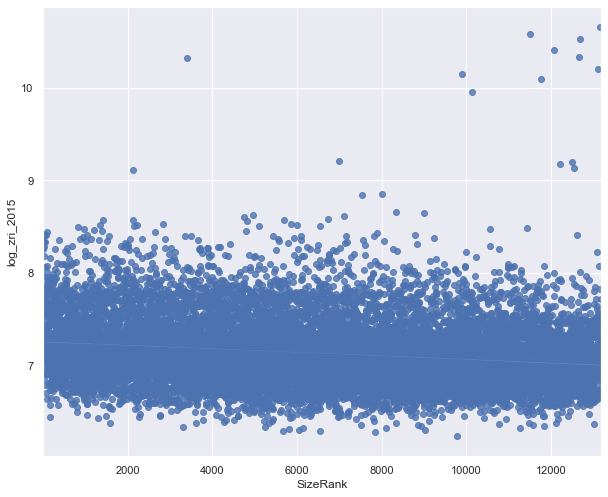

In [358]:
#Investigate what the relationship between size rank and zri is.
import seaborn as sns
sns.regplot(y = 'log_zri_2015', 
            x = "SizeRank",   
            data = zri_all_2015)

Manually select features that seem relevant for our prediction

In [91]:
select_zip = zip_codes_2015_5yr[['geo_id','percent_income_spent_on_rent', 'mortgaged_housing_units',
'families_with_young_children', 'married_households', 'occupied_housing_units',
'housing_units_renter_occupied', 'mobile_homes','housing_built_2005_or_later',
'housing_built_2000_to_2004', 'housing_built_1939_or_earlier', 'white_including_hispanic',
'black_including_hispanic', 'amerindian_including_hispanic','asian_including_hispanic',
'households_retirement_income', 'armed_forces', 'civilian_labor_force', 'employed_pop', 
'unemployed_pop', 'not_in_labor_force', 'pop_in_labor_force','high_school_diploma',
'bachelors_degree_2', 'bachelors_degree_or_higher_25_64', 'children',
'commuters_by_bus','commuters_by_car_truck_van','commuters_by_carpool',
'commuters_by_subway_or_elevated', 'commuters_by_subway_or_elevated', 
'different_house_year_ago_different_city','different_house_year_ago_same_city',
'employed_agriculture_forestry_fishing_hunting_mining','associates_degree',
'employed_arts_entertainment_recreation_accommodation_food',
'employed_construction','employed_education_health_social','bachelors_degree',
'employed_finance_insurance_real_estate','employed_information','employed_manufacturing',
'employed_other_services_not_public_admin','employed_public_administration',
'employed_retail_trade', 'employed_science_management_admin_waste',
'employed_transportation_warehousing_utilities', 'employed_wholesale_trade',
'female_female_households','four_more_cars', 'gini_index', 'graduate_professional_degree',
'group_quarters', 'high_school_including_ged', 'households_public_asst_or_food_stamps',
'in_school','in_undergrad_college','less_than_high_school_graduate',
'male_male_households','management_business_sci_arts_employed','no_cars',
'not_us_citizen_pop','occupation_management_arts', 'one_car','two_cars',
'occupation_natural_resources_construction_maintenance', 'worked_at_home',
'occupation_production_transportation_material','occupation_sales_office',
'occupation_services', 'three_cars','sales_office_employed','walked_to_work',
'some_college_and_associates_degree', 'less_one_year_college','masters_degree',
'one_year_more_college', 'hispanic_any_race','pop_determined_poverty_status','poverty']]

In [92]:
zri_all_2015['RegionID'] = zri_all_2015['RegionID'].astype(str)

<ipython-input-92-b4c0016b53aa>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  zri_all_2015['RegionID'] = zri_all_2015['RegionID'].astype(str)


In [93]:
full_df_all = pd.merge(zri_all_2015, select_zip , how = 'inner',
                       left_on = 'RegionID', right_on = 'geo_id')

In [94]:
full_df_all.drop(columns = 'geo_id', inplace = True)

In [95]:
full_df_all.shape

(4305, 86)

Investigate missingness

In [96]:
# Generate the boolean flags indicating missing rows and columns
missingRows = pd.isnull(full_df_all).sum(axis=1) > 0
missingCols = pd.isnull(full_df_all).sum(axis=0) > 0
print('The columns with missingness are %s' %(full_df_all.columns[missingCols]))

The columns with missingness are Index(['mean_2015', 'mean_2014', 'mean_2013', 'percent_income_spent_on_rent',
       'gini_index'],
      dtype='object')


In [97]:
nulls = full_df_all.isnull().sum(axis = 0)
nulls[nulls>1].sort_values()

mean_2015                        63
mean_2014                        73
gini_index                      113
mean_2013                       330
percent_income_spent_on_rent    769
dtype: int64

In [98]:
full_df_all['percent_income_spent_on_rent'] = full_df_all['percent_income_spent_on_rent'
                                                         ].replace('None',
                                                          np.nan).astype(float)

In [99]:
#impute the missing percent income spent on rent by the median of the city
full_df_all['percent_income_spent_on_rent'] = full_df_all['percent_income_spent_on_rent'
                                              ].fillna(full_df_all.groupby('City'
                                              )['percent_income_spent_on_rent'
                                               ].transform('median'))

In [100]:
#A few did not have a city median, so they got imputed by the median of the state
full_df_all['percent_income_spent_on_rent'] = full_df_all['percent_income_spent_on_rent'
                                              ].fillna(full_df_all.groupby('State'
                                              )['percent_income_spent_on_rent'
                                               ].transform('median'))

In [101]:
nulls = full_df_all.isnull().sum(axis = 0)
nulls[nulls>1].sort_values()

mean_2015      63
mean_2014      73
gini_index    113
mean_2013     330
dtype: int64

Imputing gini_index by the City's median

In [102]:
full_df_all['gini_index'] = full_df_all['gini_index'].astype(float)
full_df_all['gini_index'] = full_df_all['gini_index'
                                              ].fillna(full_df_all.groupby('City'
                                              )['gini_index'
                                               ].transform('median'))

In [103]:
nulls = full_df_all.isnull().sum(axis = 0)
nulls[nulls>1].sort_values()

gini_index     61
mean_2015      63
mean_2014      73
mean_2013     330
dtype: int64

In [104]:
full_df_all['gini_index'] = full_df_all['gini_index'].astype(float)
full_df_all['gini_index'] = full_df_all['gini_index'
                                              ].fillna(full_df_all.groupby('State'
                                              )['gini_index'
                                               ].transform('median'))

In [105]:
nulls = full_df_all.isnull().sum(axis = 0)
nulls[nulls>1].sort_values()

mean_2015     63
mean_2014     73
mean_2013    330
dtype: int64

Imputing mean_2015 zri by the previous year's zri

In [106]:
full_df_all['mean_2015'] = full_df_all['mean_2015'].fillna(full_df_all['mean_2014'])

In [107]:
nulls = full_df_all.isnull().sum(axis = 0)
nulls[nulls>1].sort_values()

mean_2015     51
mean_2014     73
mean_2013    330
dtype: int64

In [108]:
full_df_all['mean_2015'] = full_df_all['mean_2015'].fillna(full_df_all['mean_2013'])

In [109]:
nulls = full_df_all.isnull().sum(axis = 0)
nulls[nulls>1].sort_values()

mean_2015     48
mean_2014     73
mean_2013    330
dtype: int64

In [110]:
full_df_all = full_df_all.drop(columns = ['mean_2014', 'mean_2013','log_zri_2015'])

In [111]:
nulls = full_df_all.isnull().sum(axis = 0)
nulls[nulls>1].sort_values()

mean_2015    48
dtype: int64

In [112]:
#drop the rows without a label value
full_df_all = full_df_all.dropna()

In [113]:
full_df_all.sample(3)

,mean_2015,RegionID,City,State,SizeRank,percent_income_spent_on_rent,mortgaged_housing_units,families_with_young_children,married_households,occupied_housing_units,housing_units_renter_occupied,mobile_homes,housing_built_2005_or_later,housing_built_2000_to_2004,housing_built_1939_or_earlier,white_including_hispanic,black_including_hispanic,amerindian_including_hispanic,asian_including_hispanic,households_retirement_income,armed_forces,civilian_labor_force,employed_pop,unemployed_pop,not_in_labor_force,pop_in_labor_force,high_school_diploma,bachelors_degree_2,bachelors_degree_or_higher_25_64,children,commuters_by_bus,commuters_by_car_truck_van,commuters_by_carpool,commuters_by_subway_or_elevated,commuters_by_subway_or_elevated,different_house_year_ago_different_city,different_house_year_ago_same_city,employed_agriculture_forestry_fishing_hunting_mining,associates_degree,employed_arts_entertainment_recreation_accommodation_food,employed_construction,employed_education_health_social,bachelors_degree,employed_finance_insurance_real_estate,employed_information,employed_manufacturing,employed_other_services_not_public_admin,employed_public_administration,employed_retail_trade,employed_science_management_admin_waste,employed_transportation_warehousing_utilities,employed_wholesale_trade,female_female_households,four_more_cars,gini_index,graduate_professional_degree,group_quarters,high_school_including_ged,households_public_asst_or_food_stamps,in_school,in_undergrad_college,less_than_high_school_graduate,male_male_households,management_business_sci_arts_employed,no_cars,not_us_citizen_pop,occupation_management_arts,one_car,two_cars,occupation_natural_resources_construction_maintenance,worked_at_home,occupation_production_transportation_material,occupation_sales_office,occupation_services,three_cars,sales_office_employed,walked_to_work,some_college_and_associates_degree,less_one_year_college,masters_degree,one_year_more_college,hispanic_any_race,pop_determined_poverty_status,poverty
1436,1874.461538,98314,Davis,CA,4309,29.1,0E-9,13.000000000,17.000000000,17.000000000,17.000000000,0E-9,0E-9,0E-9,5.000000000,1899.000000000,368.000000000,25.000000000,145.000000000,0E-9,2578.000000000,4.000000000,4.000000000,0E-9,21.000000000,2582.000000000,147.000000000,144.000000000,218.000000000,47.000000000,187.000000000,123.000000000,0E-9,0E-9,0E-9,1267.000000000,239.000000000,0E-9,209.000000000,0E-9,0E-9,0E-9,144.000000000,0E-9,0E-9,0E-9,0E-9,0E-9,4.000000000,0E-9,0E-9,0E-9,0E-9,0E-9,0.0633,74.000000000,2561.000000000,147.000000000,0E-9,336.000000000,264.000000000,0E-9,0E-9,4.000000000,0E-9,15.000000000,4.000000000,0E-9,17.000000000,0E-9,776.000000000,0E-9,0E-9,0E-9,0E-9,0E-9,1496.000000000,571.000000000,52.000000000,66.000000000,310.000000000,240.000000000,81.000000000,0E-9
2349,1974.692308,71045,Atlanta,GA,7137,34.0,113.000000000,13.000000000,145.000000000,269.000000000,35.000000000,137.000000000,0E-9,10.000000000,12.000000000,542.000000000,45.000000000,0E-9,0E-9,50.000000000,0E-9,261.000000000,236.000000000,25.000000000,242.000000000,261.000000000,173.000000000,35.000000000,31.000000000,103.000000000,0E-9,201.000000000,49.000000000,0E-9,0E-9,11.000000000,13.000000000,16.000000000,11.000000000,0E-9,33.000000000,43.000000000,35.000000000,3.000000000,9.000000000,12.000000000,14.000000000,51.000000000,38.000000000,0E-9,15.000000000,2.000000000,0E-9,13.000000000,0.3950,15.000000000,0E-9,218.000000000,61.000000000,126.000000000,34.000000000,81.000000000,0E-9,85.000000000,26.000000000,0E-9,85.000000000,76.000000000,95.000000000,48.000000000,0E-9,21.000000000,78.000000000,4.000000000,59.000000000,78.000000000,8.000000000,93.000000000,47.000000000,15.000000000,35.000000000,0E-9,587.000000000,109.000000000
196,1843.846154,60560,North Bergen Township,NJ,570,32.4,4851.000000000,1863.000000000,5051.000000000,7509.000000000,1225.000000000,24.000000000,0E-9,304.000000000,104.000000000,19857.000000000,1285.000000000,18.000000000,377.000000000,1247.000000000,0E-9,1

In [115]:
#add poverty rate feature
full_df_all['poverty_rate']= full_df_all['poverty'].astype(float
                            )/full_df_all['pop_determined_poverty_status'].astype(float)
full_df_all = full_df_all.drop(columns = ['poverty', 'pop_determined_poverty_status'])

In [128]:
#impute poverty rate by City's median

full_df_all['poverty_rate'] = full_df_all['poverty_rate'].astype(float)
full_df_all['poverty_rate'] = full_df_all['poverty_rate'
                                              ].fillna(full_df_all.groupby('State'
                                              )['poverty_rate'
                                               ].transform('median'))

In [129]:
nulls = full_df_all.isnull().sum(axis = 0)
nulls[nulls>1].sort_values()

Series([], dtype: int64)

In [130]:
full_df_all.columns

Index(['mean_2015', 'RegionID', 'City', 'State', 'SizeRank',
       'percent_income_spent_on_rent', 'mortgaged_housing_units',
       'families_with_young_children', 'married_households',
       'occupied_housing_units', 'housing_units_renter_occupied',
       'mobile_homes', 'housing_built_2005_or_later',
       'housing_built_2000_to_2004', 'housing_built_1939_or_earlier',
       'white_including_hispanic', 'black_including_hispanic',
       'amerindian_including_hispanic', 'asian_including_hispanic',
       'households_retirement_income', 'armed_forces', 'civilian_labor_force',
       'employed_pop', 'unemployed_pop', 'not_in_labor_force',
       'pop_in_labor_force', 'high_school_diploma', 'bachelors_degree_2',
       'bachelors_degree_or_higher_25_64', 'children', 'commuters_by_bus',
       'commuters_by_car_truck_van', 'commuters_by_carpool',
       'commuters_by_subway_or_elevated', 'commuters_by_subway_or_elevated',
       'different_house_year_ago_different_city',
       'diff

<AxesSubplot:ylabel='Count'>

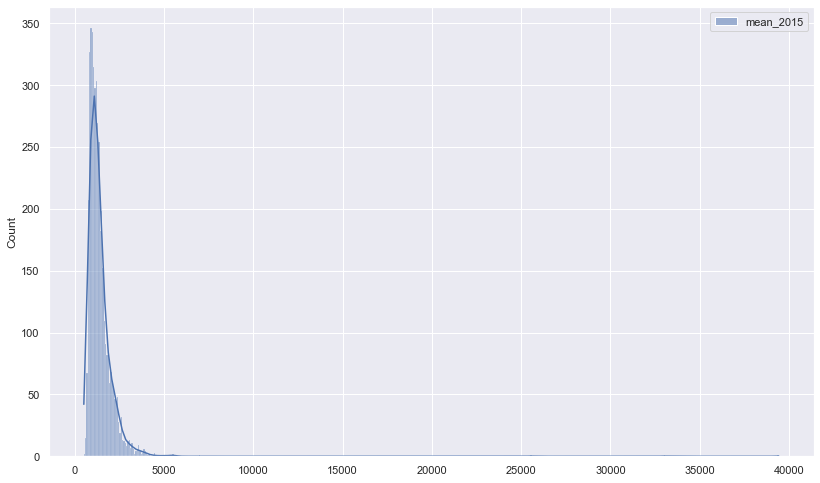

In [140]:
label = full_df_all[['mean_2015']]
sns.histplot(label,kde = True)

the zri is right skewd. Use log zri to fix it

In [141]:
label = np.log(label)

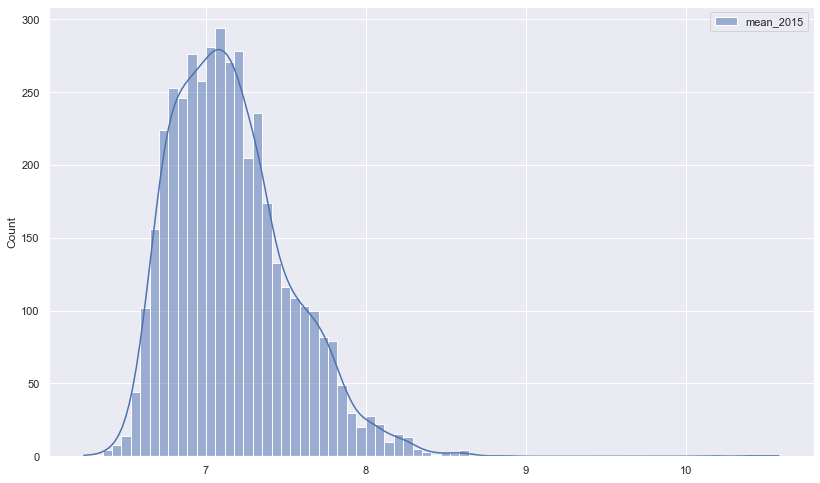

In [143]:
sns.histplot(label,kde = True);

log(zri) is closer to be normally distributed, so use this as the label!

### Features; evaluating multicollinearity and correlation

In [171]:
features = full_df_all.drop(columns = [ 'City', 'mean_2015',
                                   'State','RegionID', 'commuters_by_subway_or_elevated'])
features = features.apply(pd.to_numeric)

In [172]:
from sklearn.linear_model import LinearRegression

feature_columns = features.columns
scores = {}
ols2 = LinearRegression()
from sklearn.metrics import r2_score
for feature_name in feature_columns:
                df2     = features.copy()
                feature = df2[feature_name].copy()
                df2.drop(feature_name, axis=1, inplace=True)
                ols2.fit(df2, feature)
                scores[feature_name] = ols2.score(df2, feature)   

''

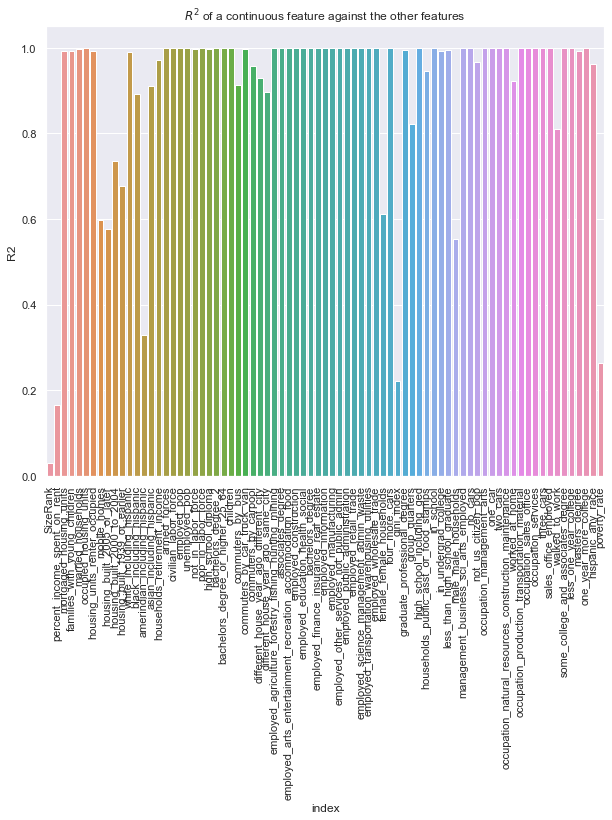

In [173]:
import seaborn as sns
g = sns.barplot(x='index', y='R2', data=pd.DataFrame(scores, index=['R2']).T.reset_index())
plt.title('$R^2$ of a continuous feature against the other features')
plt.xticks(rotation=90);

<AxesSubplot:>

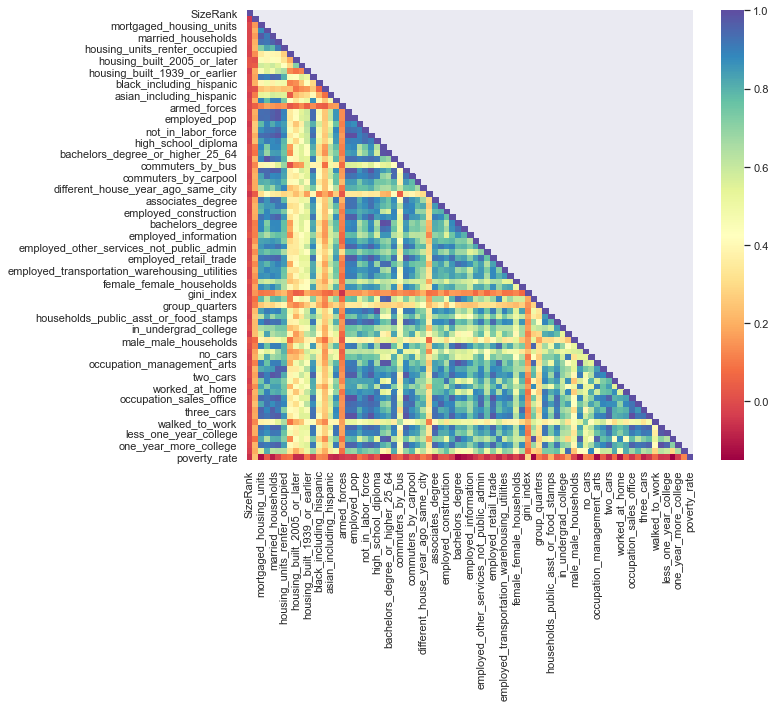

In [174]:
corr_df =  features.corr(method='pearson') 

df_lt = corr_df.where(np.tril(np.ones(corr_df.shape)).astype(np.bool))

hmap=sns.heatmap(df_lt,cmap="Spectral")
hmap

In [175]:
from statsmodels.stats.outliers_influence import variance_inflation_factor 

vif_data = pd.DataFrame() 
vif_data["feature"] = features.columns 
  
# calculating VIF for each feature 
vif_data["VIF"] = [variance_inflation_factor(features.values, i) 
                          for i in range(len(features.columns))] 
  
print(vif_data)

/Applications/anaconda3/lib/python3.8/site-packages/statsmodels/stats/outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


                                              feature          VIF
0                                            SizeRank     3.745814
1                        percent_income_spent_on_rent    13.241821
2                             mortgaged_housing_units   198.954725
3                        families_with_young_children   169.314237
4                                  married_households   369.475867
5                              occupied_housing_units          inf
6                       housing_units_renter_occupied   165.427323
7                                        mobile_homes     3.190377
8                         housing_built_2005_or_later     2.534463
9                          housing_built_2000_to_2004     4.317320
10                      housing_built_1939_or_earlier     3.687101
11                           white_including_hispanic   136.844266
12                           black_including_hispanic    10.202046
13                      amerindian_including_hispanic     1.62

In [365]:
features_less = features.drop(columns = ['SizeRank','children', 'commuters_by_car_truck_van',
                                        'armed_forces', 'civilian_labor_force','pop_in_labor_force',
                                        'employed_arts_entertainment_recreation_accommodation_food',
                                        'employed_construction', 'employed_wholesale_trade',
                                         'four_more_cars','occupation_production_transportation_material',
                                         'some_college_and_associates_degree', 'bachelors_degree_2',
                                        'management_business_sci_arts_employed', 'occupation_sales_office',
                                        'occupied_housing_units', 'not_in_labor_force','employed_pop',
                                        'bachelors_degree_or_higher_25_64', 'married_households',
                                        'high_school_diploma','occupation_management_arts','two_cars',
                                        'in_school', 'sales_office_employed','masters_degree',
                                        'mortgaged_housing_units', 'white_including_hispanic',
                                        'housing_units_renter_occupied','one_car','bachelors_degree',
                                        'employed_education_health_social','families_with_young_children',
                                        'one_year_more_college','high_school_including_ged',
                                        'less_than_high_school_graduate','occupation_services',
                                        'associates_degree','three_cars', 'less_one_year_college',
                                        'employed_retail_trade', 'commuters_by_carpool'])

In [366]:
vif_data2 = pd.DataFrame() 
vif_data2["feature"] = features_less.columns 
  
# calculating VIF for each feature 
vif_data2["VIF"] = [variance_inflation_factor(features_less.values, i) 
                          for i in range(len(features_less.columns))] 
  
print(vif_data2)

                                              feature        VIF
0                        percent_income_spent_on_rent  12.828147
1                                        mobile_homes   2.287587
2                         housing_built_2005_or_later   2.323820
3                          housing_built_2000_to_2004   3.582036
4                       housing_built_1939_or_earlier   2.753792
5                            black_including_hispanic   2.949931
6                       amerindian_including_hispanic   1.327998
7                            asian_including_hispanic   3.224462
8                        households_retirement_income  12.162230
9                                      unemployed_pop  16.681866
10                                   commuters_by_bus   5.729494
11            different_house_year_ago_different_city  11.351130
12                 different_house_year_ago_same_city   6.958063
13  employed_agriculture_forestry_fishing_hunting_...   2.601112
14             employed_f

In [367]:
feature_columns = features_less.columns
scores = {}
ols2 = LinearRegression()
from sklearn.metrics import r2_score
for feature_name in feature_columns:
                df2     = features_less.copy()
                feature = df2[feature_name].copy()
                df2.drop(feature_name, axis=1, inplace=True)
                ols2.fit(df2, feature)
                scores[feature_name] = ols2.score(df2, feature)  

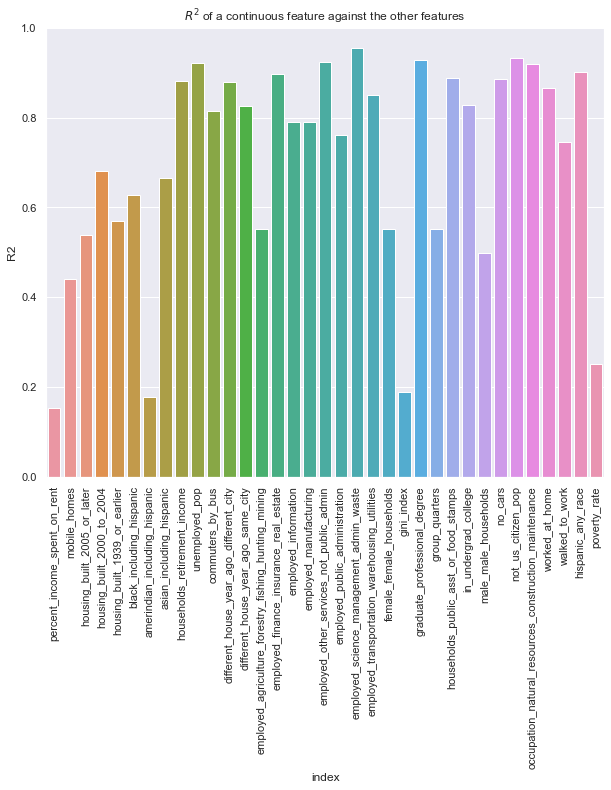

In [368]:
g2 = sns.barplot(x='index', y='R2', data=pd.DataFrame(scores, index=['R2']).T.reset_index())
plt.title('$R^2$ of a continuous feature against the other features')
plt.xticks(rotation=90);

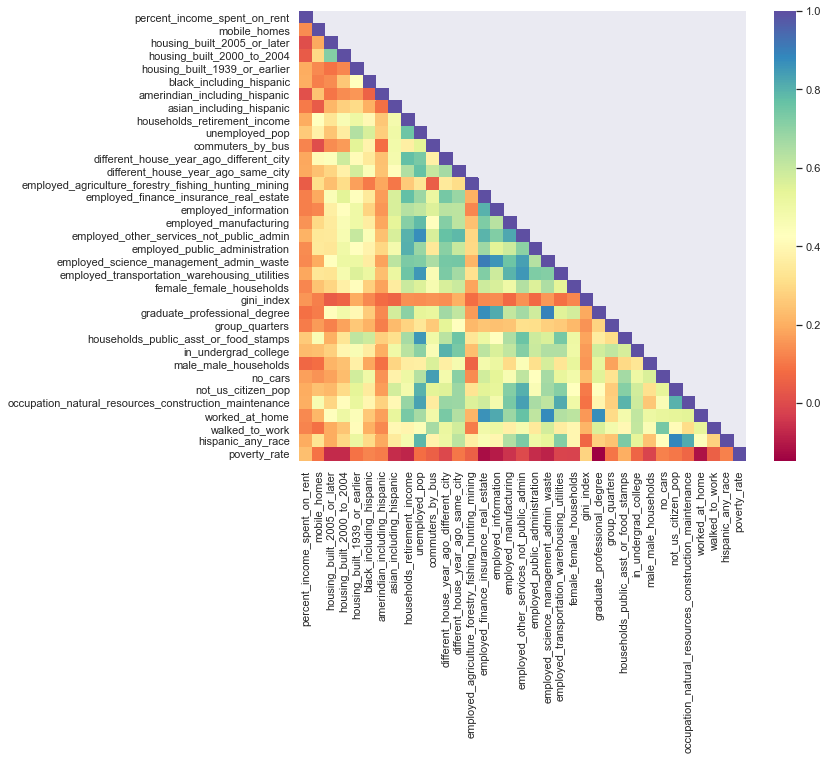

In [369]:
corr_df =  features_less.corr(method='pearson') 

df_lt = corr_df.where(np.tril(np.ones(corr_df.shape)).astype(np.bool))

hmap=sns.heatmap(df_lt,cmap="Spectral")
hmap; 

Now there are not quite as many features with high VIFs and less multicolinearity overall.

# OLS

In [370]:
from sklearn.model_selection import train_test_split
X = features_less.copy()
y = label

Xtrain, Xtest, ytrain, ytest = train_test_split(X,
                                                y,
                                                random_state = 1)

In [371]:
print(Xtrain.shape, Xtest.shape , ytrain.shape, ytest.shape)

(3192, 35) (1065, 35) (3192, 1) (1065, 1)


In [372]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Fix the scale model using the train set
scaler.fit(Xtrain)
Xtrain_scaled = scaler.transform(Xtrain)
Xtest_scaled  = scaler.transform(Xtest)

In [373]:
Xtrain_scaled = pd.DataFrame(data =Xtrain_scaled, columns = Xtrain.columns)
Xtest_scaled = pd.DataFrame(data =Xtest_scaled, columns = Xtest.columns)

In [374]:
from sklearn.linear_model import LinearRegression
ols = LinearRegression()

ols.fit(Xtrain_scaled,ytrain)

print(f'Linear regression training score: {ols.score(Xtrain_scaled,ytrain)}')
print(f'Linear regression testing score: {ols.score(Xtest_scaled,ytest)}')

from sklearn.metrics import mean_squared_error
y_pred = ols.predict(Xtest_scaled)
RMSE = mean_squared_error(ytest,y_pred,squared = False)
print(f'Linear regression RMSE: {RMSE}')

Linear regression training score: 0.059974551869519166
Linear regression testing score: 0.05935599013484827
Linear regression RMSE: 0.3498844464103798


### Lasso

In [375]:
from sklearn.model_selection import KFold
from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate, cross_val_score



cv = KFold(n_splits = 5, shuffle = True)


lasso = Lasso(max_iter = 500000)
alphas = np.linspace(.00000001,1,10)

#manual grid search for ideal alpha
cv_res=[]

for alpha in alphas:
    lasso.set_params(alpha = alpha)
    pipe = Pipeline(steps = [('lasso', lasso)])
    cv_res.append(cross_validate(pipe,Xtrain_scaled,ytrain,
                                 cv = cv, return_train_score = True))

lasso_test = [i['test_score'].mean() for i in cv_res]
lasso_train = [i['train_score'].mean() for i in cv_res]


In [376]:
print(alphas)
print(lasso_train)
print(lasso_test)

[1.0000000e-08 1.1111112e-01 2.2222223e-01 3.3333334e-01 4.4444445e-01
 5.5555556e-01 6.6666667e-01 7.7777778e-01 8.8888889e-01 1.0000000e+00]
[0.06197125843132112, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.040167392035827684, -0.00278819413494098, -0.001043178763262409, -0.0007273158097437004, -0.0005863589619259813, -0.0013998855476737848, -0.0021918783513332762, -0.0048745800157269596, -0.00029070866847140663, -0.0018219196170597752]


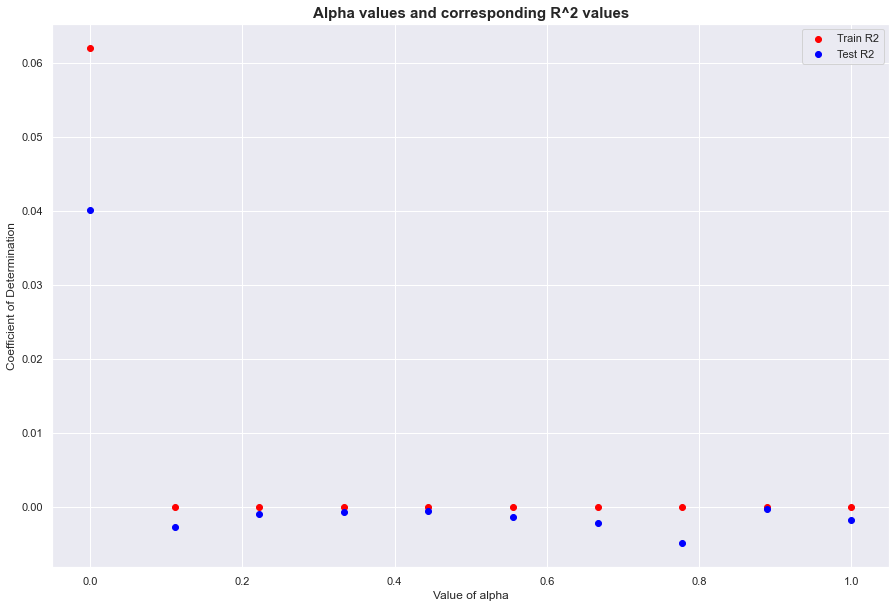

In [377]:
##Plot the alphas and R^2
plt.figure(figsize = (15,10))
plt.scatter(alphas, lasso_train, c = 'red')
plt.scatter(alphas, lasso_test, c = 'blue')

plt.title(r'Alpha values and corresponding R^2 values',fontsize = 15, fontweight = 'bold')
plt.xlabel('Value of alpha')
plt.ylabel('Coefficient of Determination')
plt.legend(['Train R2', 'Test R2'])


In [378]:
lasso.set_params(alpha =.00000001 )

Lasso(alpha=1e-08, max_iter=500000)

In [379]:
lasso.fit(Xtrain, ytrain)

Lasso(alpha=1e-08, max_iter=500000)

In [380]:
#Identify columns from Lasso regression that can be removed from model
coefs = lasso.coef_
zero_idx = np.where(coefs <= 0)
features_less.columns[zero_idx]

Index(['mobile_homes', 'housing_built_2000_to_2004',
       'housing_built_1939_or_earlier', 'black_including_hispanic',
       'amerindian_including_hispanic', 'asian_including_hispanic',
       'different_house_year_ago_different_city',
       'different_house_year_ago_same_city', 'employed_information',
       'employed_other_services_not_public_admin',
       'employed_science_management_admin_waste', 'female_female_households',
       'gini_index', 'graduate_professional_degree', 'group_quarters',
       'no_cars', 'occupation_natural_resources_construction_maintenance',
       'hispanic_any_race', 'poverty_rate'],
      dtype='object')

In [381]:
lasso.coef_

array([ 9.30251722e-04, -8.20227327e-05,  4.70874991e-04, -1.43012747e-04,
       -6.19404311e-05, -1.88849888e-05, -3.48235359e-05, -2.72816127e-06,
        2.01214253e-05,  1.11940167e-04,  4.73383645e-05, -3.20359993e-05,
       -3.28819067e-05,  9.08685616e-05,  8.76411342e-06, -9.76600720e-05,
        3.95878005e-05, -8.23396120e-05,  4.61464368e-05, -7.36230616e-06,
        4.53962025e-05, -3.14811486e-04, -2.15226583e-01, -8.17860170e-06,
       -2.78318522e-06,  9.95182719e-05,  1.95018870e-05,  2.09805696e-04,
       -4.59821877e-05,  1.56189641e-05, -2.07393489e-05,  2.34979296e-05,
        7.09920505e-05, -1.77661280e-05, -1.20559861e-01])

In [382]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from math import sqrt

pred_train_lasso= lasso.predict(Xtrain)
print(np.sqrt(mean_squared_error(ytrain,pred_train_lasso)))
print(r2_score(ytrain, pred_train_lasso))

pred_test_lasso=  lasso.predict(Xtest)
print(np.sqrt(mean_squared_error(ytest,pred_test_lasso))) 
print(r2_score(ytest, pred_test_lasso))

0.3643609631498488
0.05997455186934619
0.3498844539003166
0.05935594986232784


### Random forest

In [399]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import  GridSearchCV, KFold

rfr = RandomForestRegressor()
rfr.fit(Xtrain_scaled, np.ravel(ytrain))
rfr.score(Xtrain_scaled, np.ravel(ytrain))

0.870088288530682

In [401]:
rfr.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [387]:
feat_imp = pd.Series(rfr.feature_importances_, index = Xtrain_scaled.columns)
feat_imp.sort_values(ascending = False)

gini_index                                               0.061984
percent_income_spent_on_rent                             0.056586
hispanic_any_race                                        0.052526
black_including_hispanic                                 0.044501
poverty_rate                                             0.042419
mobile_homes                                             0.041222
employed_agriculture_forestry_fishing_hunting_mining     0.039666
walked_to_work                                           0.036399
employed_manufacturing                                   0.032052
housing_built_1939_or_earlier                            0.031987
households_retirement_income                             0.030723
unemployed_pop                                           0.029268
occupation_natural_resources_construction_maintenance    0.028083
different_house_year_ago_different_city                  0.027999
employed_transportation_warehousing_utilities            0.027723
employed_p

In [402]:
rfr.score(Xtest_scaled, ytest)

0.08445426006862478

In [391]:
#parameters grid
params = {'ccp_alpha':[0,0.5], #lets decrease the size of each tree
         'n_estimators': [10,50,100],
         'min_samples_leaf':[1,2,5,10]}
cv = KFold(n_splits = 5, shuffle= True)

grid = GridSearchCV(estimator = rfr,
                   param_grid = params,
                   cv = cv,
                   return_train_score = True)


In [393]:
grid.fit(Xtrain_scaled, np.ravel(ytrain))

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=True),
             estimator=RandomForestRegressor(),
             param_grid={'ccp_alpha': [0, 0.5, 1],
                         'min_samples_leaf': [1, 2, 5, 10],
                         'n_estimators': [10, 50, 100]},
             return_train_score=True)

In [394]:
grid.best_params_


{'ccp_alpha': 0, 'min_samples_leaf': 10, 'n_estimators': 100}

In [396]:
best_rf = grid.best_estimator_
best_rf.score(Xtrain_scaled, ytrain)

0.4893970761893015

In [403]:
best_rf.score(Xtest_scaled, ytest)

0.1064743577454007

overfit? try with all the features

In [404]:
features = features.T.drop_duplicates().T

In [407]:
X2 = features.copy()
y2 = label

Xtrain2, Xtest2, ytrain2, ytest2 = train_test_split(X2,
                                                y2)

In [408]:
print(Xtrain2.shape, Xtest2.shape , ytrain2.shape, ytest2.shape)

(3192, 74) (1065, 74) (3192, 1) (1065, 1)


In [409]:
# Fix the scale model using the train set
scaler.fit(Xtrain2)
Xtrain2_scaled = scaler.transform(Xtrain2)
Xtest2_scaled  = scaler.transform(Xtest2)

In [413]:
Xtrain2_scaled = pd.DataFrame(data =Xtrain2_scaled, columns = Xtrain2.columns)
Xtest2_scaled = pd.DataFrame(data =Xtest2_scaled, columns = Xtest2.columns)

In [415]:
rfr2 = RandomForestRegressor()
rfr2.fit(Xtrain2_scaled, np.ravel(ytrain2))
rfr2.score(Xtrain2_scaled, np.ravel(ytrain2))

0.8732677923009688

In [417]:
rfr2.score(Xtest2_scaled, ytest2)

0.132073936847648

In [418]:
#parameters grid
params2 = {'ccp_alpha':[0,0.5], #lets decrease the size of each tree
         'n_estimators': [10,50,100],
         'min_samples_leaf':[1,2,5,10]}

grid2 = GridSearchCV(estimator = rfr2,
                   param_grid = params2,
                   cv = cv,
                   return_train_score = True)

In [419]:
grid2.fit(Xtrain2_scaled, np.ravel(ytrain2))

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=True),
             estimator=RandomForestRegressor(),
             param_grid={'ccp_alpha': [0, 0.5],
                         'min_samples_leaf': [1, 2, 5, 10],
                         'n_estimators': [10, 50, 100]},
             return_train_score=True)

In [420]:
grid2.best_params_


{'ccp_alpha': 0, 'min_samples_leaf': 10, 'n_estimators': 100}

In [423]:
best_rf2 = grid2.best_estimator_
best_rf2.score(Xtrain2_scaled, ytrain2)

0.5269880495834285

In [425]:
best_rf2.score(Xtest2_scaled, ytest2)

0.15386837245284524